# Importation

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import yaml

from pyoperators import (
    MPI,
    BlockRowOperator,
    DenseOperator,
    ReshapeOperator,
    PackOperator,
    IdentityOperator,
)
from pyoperators.iterative.core import AbnormalStopIteration
from pysimulators.interfaces.healpy import (
    HealpixConvolutionGaussianOperator,
    Spherical2HealpixOperator,
)

from qubic.lib.Instrument.Qacquisition import QubicInstrumentType
from qubic.lib.Instrument.Qinstrument import compute_freq
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel
from qubic.lib.MapMaking.Qatmosphere import AtmosphereMaps
from qubic.lib.MapMaking.Qcg_test_for_atm import PCGAlgorithm
from qubic.lib.Qsamplings import QubicSampling, equ2gal, get_pointing

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# Import simulation parameters
with open("params.yml", "r") as file:
    params = yaml.safe_load(file)

np.random.seed(params["seed"])

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict
qubic_dict["instrument_type"] = "DB"
qubic_dict["interp_projection"] = False

npix = hp.nside2npix(params["nside"])

# Scanning Strategy

## Galactic Coordinates

In [4]:
### Random pointing
qubic_dict["random_pointing"] = True
qubic_dict['date_obs'] = '2023-10-01 22:57:00.000'
qubic_dict['period'] = 3

### Sweepingpointing
qubic_dict["sweeping_pointing"] = False
qubic_dict["fix_azimuth"]["apply"] = False

# qubic_dict['angspeed'] = 0.4
# qubic_dict['delta_az'] = 20
# qubic_dict['nsweeps_per_elevation'] = 5
# qubic_dict['period'] = 1e-15
# qubic_dict['duration'] = 1
# npointings = 3600 * t_obs / period

### Repeat pointing
qubic_dict["repeat_pointing"] = False

qubic_dict["fix_azimuth"]["apply"] = False

q_sampling_gal = get_pointing(qubic_dict)
qubic_patch = np.array([0, -57])
center_gal = equ2gal(qubic_patch[0], qubic_patch[1])
center_local = np.array(
    [np.mean(q_sampling_gal.azimuth), np.mean(q_sampling_gal.elevation)]
)
print(q_sampling_gal)

QubicSampling((5000,), 
    index=[   0    1    2 ... 4997 4998 4999],
    angle_hwp=[30 75 30 ... 75 60 45],
    azimuth=[137.14575549 144.42263347 159.61506069 ... 169.12360131 170.0088,
    elevation=[40.17542886 37.78965996 25.64259046 ... 44.28924312 55.27570461
,
    equatorial=[[343.55767673 -50.82827123]
 [345.46653981 -56.86269522]
 [  9.4,
    galactic=[[338.09662836 -57.53681203]
 [328.57476872 -54.46712519]
 [304.4,
    masked=False,
    pitch=[275.57890577 110.94219781 264.7360378  ... 249.15064757  65.0759)


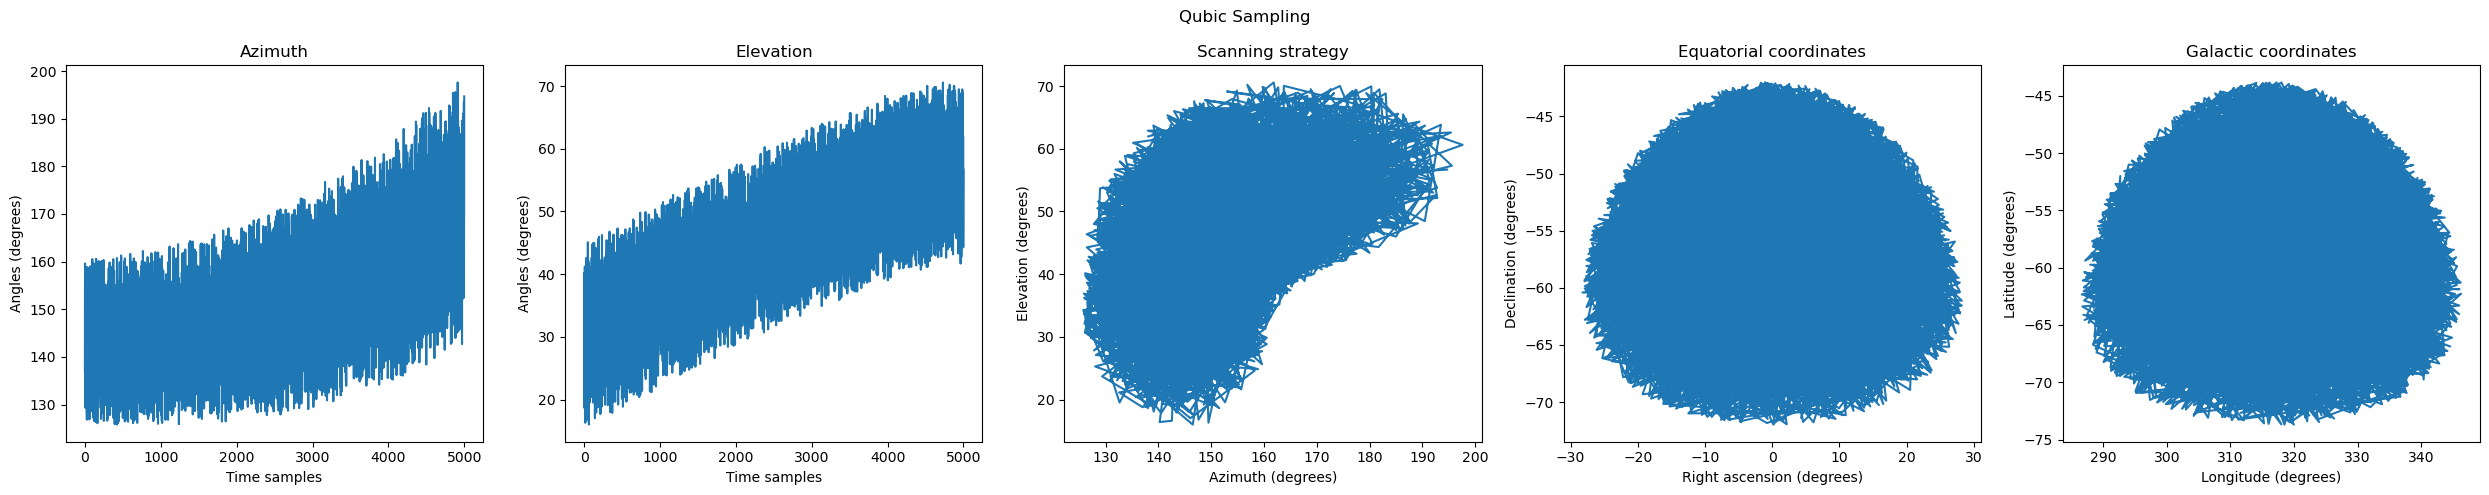

In [5]:
az, el = q_sampling_gal.azimuth, q_sampling_gal.elevation

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# Azimuth plot
axs[0].plot(az)
axs[0].set_title("Azimuth")
axs[0].set_xlabel("Time samples")
axs[0].set_ylabel("Angles (degrees)")

# Elevation plot
axs[1].plot(el)
axs[1].set_title("Elevation")
axs[1].set_xlabel("Time samples")
axs[1].set_ylabel("Angles (degrees)")

# Scanning strategy plot
axs[2].plot(az, el)
axs[2].set_title("Scanning strategy")
axs[2].set_xlabel("Azimuth (degrees)")
axs[2].set_ylabel("Elevation (degrees)")

# Equatorial coordinates plot
axs[3].plot(
    (q_sampling_gal.equatorial[:, 0] + 180) % 360 - 180, q_sampling_gal.equatorial[:, 1]
)
axs[3].set_title("Equatorial coordinates")
axs[3].set_xlabel("Right ascension (degrees)")
axs[3].set_ylabel("Declination (degrees)")

# Galactic coordinates plot
axs[4].plot(q_sampling_gal.galactic[:, 0], q_sampling_gal.galactic[:, 1])
axs[4].set_title("Galactic coordinates")
axs[4].set_xlabel("Longitude (degrees)")
axs[4].set_ylabel("Latitude (degrees)")

fig.suptitle("Qubic Sampling")
plt.tight_layout()
plt.show()

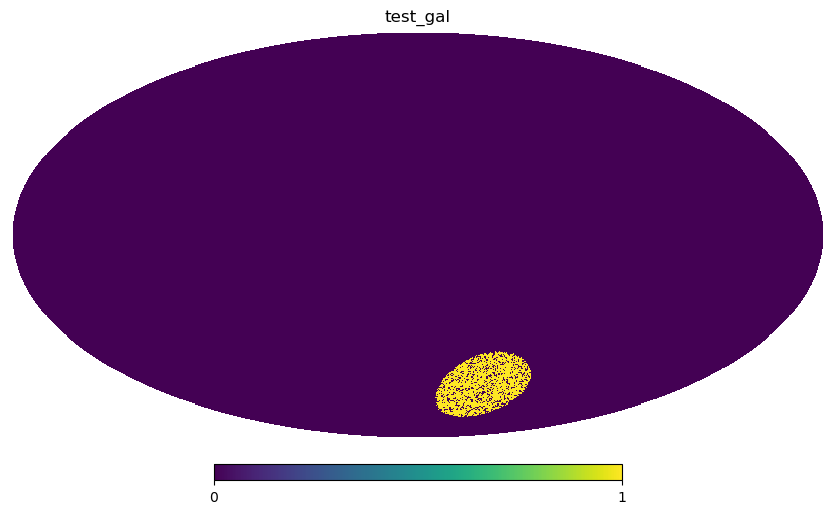

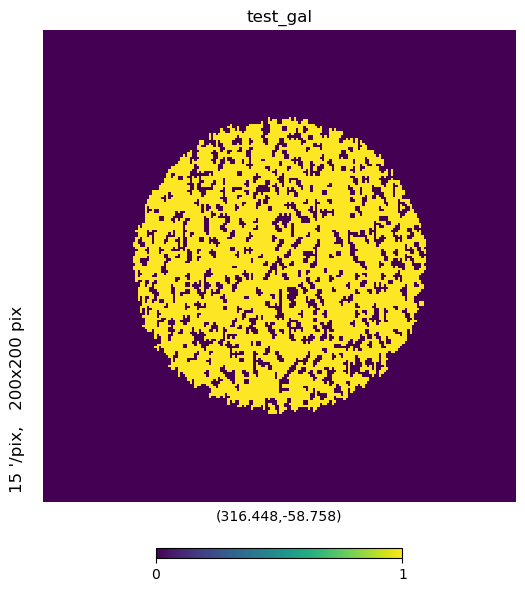

In [6]:
test_gal = np.zeros(hp.nside2npix(params["nside"]))

index = np.array(
    Spherical2HealpixOperator(params["nside"], "azimuth, elevation")(
        np.radians(q_sampling_gal.galactic)
    ),
    dtype="int",
)
test_gal[index] = 1
hp.mollview(test_gal, title="test_gal", cmap="viridis")
hp.gnomview(test_gal, title="test_gal", cmap="viridis", reso=15, rot=center_gal)

## Local Coordinates

In [7]:
q_sampling_local = QubicSampling(
    q_sampling_gal.index.size,  # int(np.ceil(qubic_dict['duration']*3600/qubic_dict['period'])),
    date_obs=qubic_dict["date_obs"],
    period=qubic_dict["period"],
    latitude=qubic_dict["latitude"],
    longitude=qubic_dict["longitude"],
)

q_sampling_local.azimuth = q_sampling_gal.azimuth
q_sampling_local.elevation = q_sampling_gal.elevation
q_sampling_local.pitch = q_sampling_gal.pitch
q_sampling_local.angle_hwp = q_sampling_gal.angle_hwp

q_sampling_local.fix_az = True

151.7686548826451 44.776691477292445


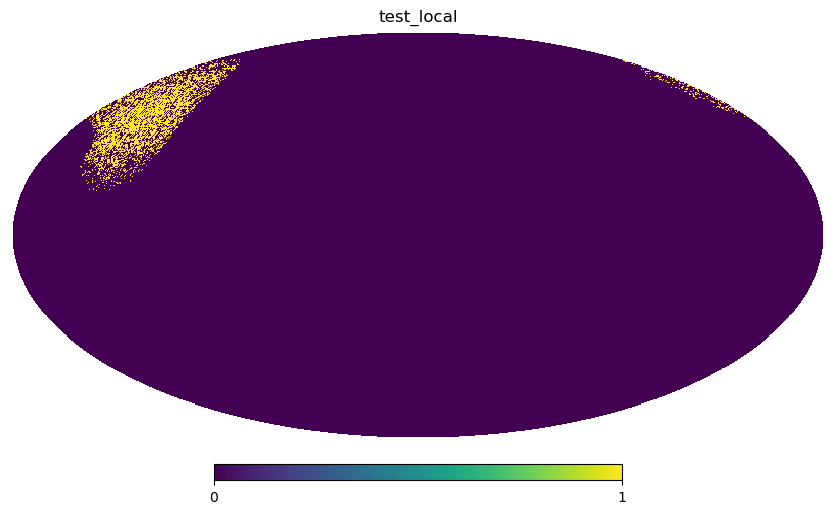

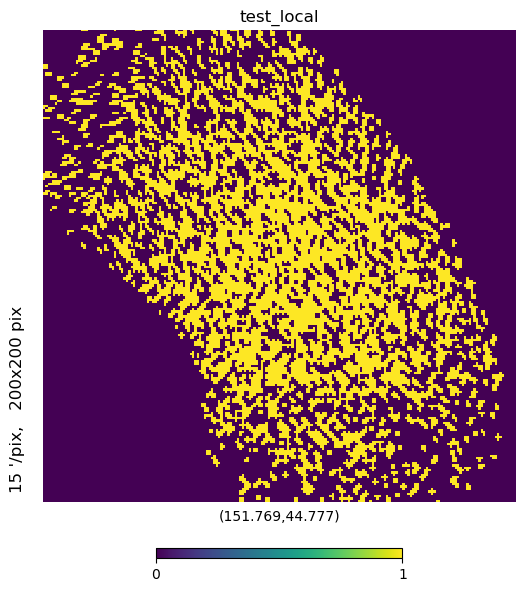

In [8]:
test_gal = np.zeros(hp.nside2npix(params["nside"]))

index = np.array(
    Spherical2HealpixOperator(params["nside"], "azimuth, elevation")(
        np.radians([q_sampling_local.azimuth, q_sampling_local.elevation]).T
    ),
    dtype="int",
)
test_gal[index] = 1
hp.mollview(test_gal, title="test_local", cmap="viridis")
hp.gnomview(
    test_gal,
    title="test_local",
    cmap="viridis",
    reso=15,
    rot=(np.mean(q_sampling_local.azimuth), np.mean(q_sampling_local.elevation)),
)

print(np.mean(q_sampling_local.azimuth), np.mean(q_sampling_local.elevation))

# Input Maps

## CMB

(8, 196608, 3)


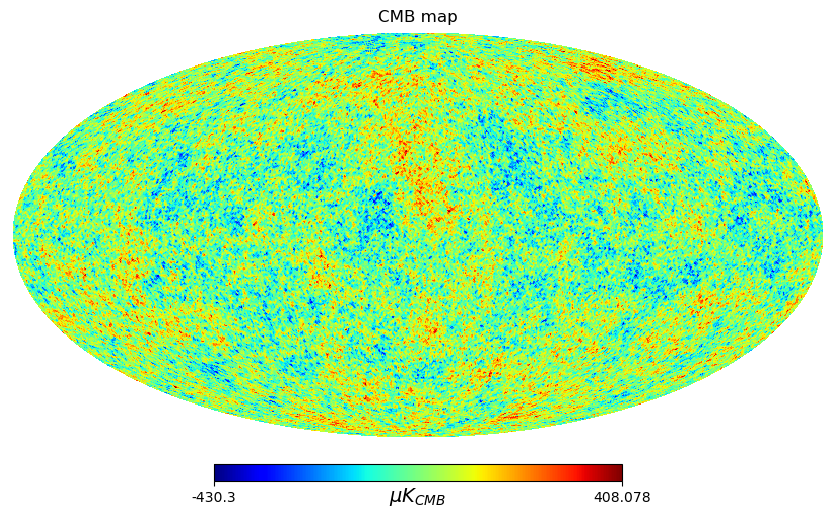

In [9]:
# Build CMB map
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
cmb_map = hp.synfast(cl_cmb, params["nside"], new=True, verbose=False).T

cmb_maps = np.ones((params["nsub_in"], hp.nside2npix(params["nside"]), 3))
cmb_maps *= cmb_map[None]
print(cmb_maps.shape)

hp.mollview(cmb_map[:, 0], cmap="jet", title="CMB map", unit=r"$µK_{CMB}$")

## Atmosphere

In [10]:
atm_maps = np.zeros((cmb_maps.shape))

# mean_rho = atm.mean_water_vapor_density
# water_vapor_map = atm.get_water_vapor_density_fluctuation_2d_map(flat=False)
# for i in range(params["nsub_in"]):
#     atm_maps[i, :, 0] = water_vapor_map
atm_maps[..., 0] = atm.get_temp_maps(atm.delta_rho_map) / 1e3

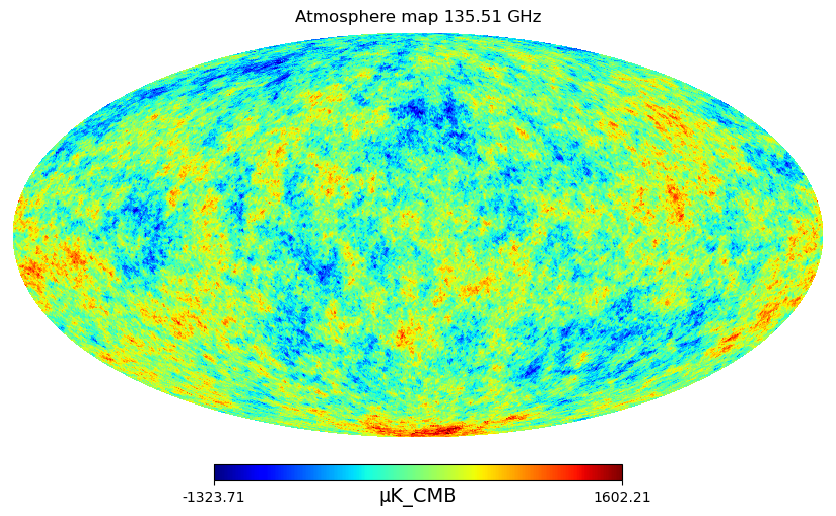

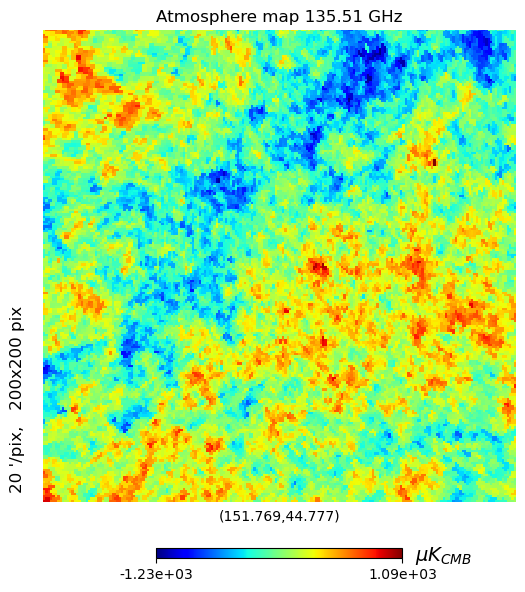

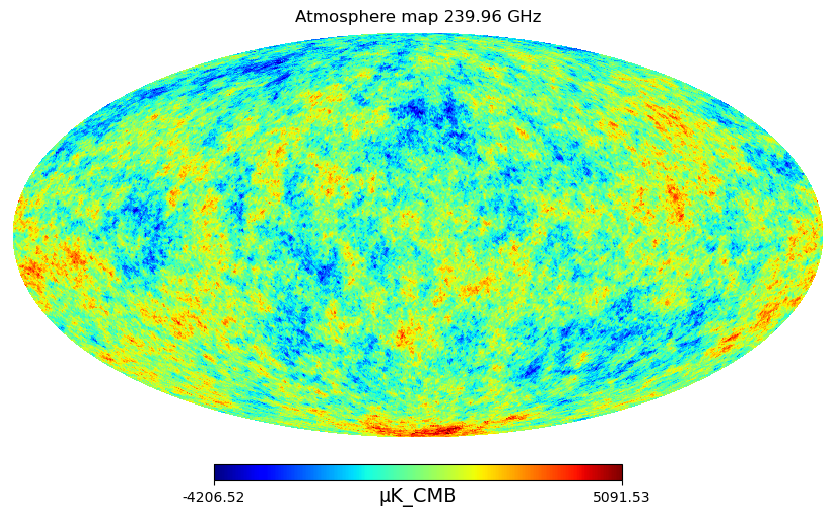

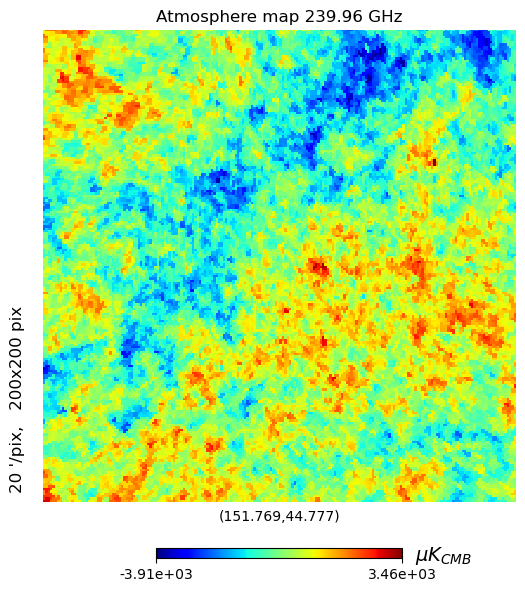

In [11]:
index_nu = 0
hp.mollview(
    atm_maps[index_nu, :, 0],
    cmap="jet",
    unit="µK_CMB",
    title="Atmosphere map {:.2f} GHz".format(atm.frequencies[index_nu]),
)
hp.gnomview(
    atm_maps[index_nu, :, 0],
    rot=center_local,
    reso=20,
    title="Atmosphere map {:.2f} GHz".format(atm.frequencies[index_nu]),
    unit=r"$µK_{CMB}$",
    cmap="jet",
)

index_nu = -1
hp.mollview(
    atm_maps[index_nu, :, 0],
    cmap="jet",
    unit="µK_CMB",
    title="Atmosphere map {:.2f} GHz".format(atm.frequencies[index_nu]),
)
hp.gnomview(
    atm_maps[index_nu, :, 0],
    rot=center_local,
    reso=20,
    title="Atmosphere map {:.2f} GHz".format(atm.frequencies[index_nu]),
    unit=r"$µK_{CMB}$",
    cmap="jet",
)

## Apply convolutions - Input Maps

In [12]:
fwhm_synthbeam150 = 0.006853589624526168

_, _, filter_nus150, deltas150, _, _ = compute_freq(
    150,
    int(params["nsub_in"] / 2),
    relative_bandwidth=qubic_dict["filter_relative_bandwidth"],
    frequency_spacing="log",
)
_, _, filter_nus220, deltas220, _, _ = compute_freq(220, int(params["nsub_in"] / 2), relative_bandwidth=qubic_dict["filter_relative_bandwidth"], frequency_spacing="log")

nus_tod = np.concatenate((filter_nus150, filter_nus220)) * 1e9
fwhm_tod = fwhm_synthbeam150 * 150e9 / nus_tod

In [13]:
for isub in range(nus_tod.size):
    C = HealpixConvolutionGaussianOperator(fwhm=fwhm_tod[isub])
    atm_maps[isub] = C(atm_maps[isub])
    cmb_maps[isub] = C(cmb_maps[isub])

## Input Maps

In [14]:
input_maps = np.zeros((2 * params["nsub_in"], hp.nside2npix(params["nside"]), 3))

input_maps[: params["nsub_in"]] = cmb_maps
input_maps[params["nsub_in"] :] = atm_maps

## True maps

In [15]:
### Build Expected Atm Maps
true_maps = np.zeros((2, 12 * params["nside"] ** 2, 3))

# Build the reconstructed maps and frequency by taking the mean inside each reconstructed frequency band
C = HealpixConvolutionGaussianOperator(fwhm=np.mean(fwhm_tod))
true_maps[0] = C(cmb_map)
true_maps[1] = C(np.mean(atm_maps, axis=0))

min_input = np.min(true_maps, axis=1)
max_input = np.max(true_maps, axis=1)

max = np.max([min_input, max_input], axis=0)
min_input = -max
max_input = max

# Mixing Matrix

In [16]:
MixingMatrix = np.ones((params["nsub_in"], 2))
# Atm mixing matrix
MixingMatrix[:, 1] = atm.temperature * atm.integrated_abs_spectrum * atm.mean_water_vapor_density

print(MixingMatrix.shape)
print(MixingMatrix[:, 1, None].shape)

(8, 2)
(8, 1)


# Build QUBIC Instances

In [17]:
q_acquisition_local = QubicInstrumentType(
    qubic_dict, params["nsub_in"], params["nsub_in"], sampling=q_sampling_local
)

q_acquisition_gal = QubicInstrumentType(
    qubic_dict, params["nsub_in"], params["nsub_in"], sampling=q_sampling_gal
)

Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (4960000,9) elements = 681.15234375 MiB in FSRRotation3dMatrix.__init__.


In [18]:
coverage_gal = q_acquisition_gal.coverage
covnorm_gal = coverage_gal / coverage_gal.max()
seenpix_gal = covnorm_gal > params["coverage_cut"]
seenpix_gal_wo_cut = covnorm_gal > 0

coverage_local = q_acquisition_local.coverage
covnorm_local = coverage_local / coverage_local.max()
seenpix_local = covnorm_local > params["coverage_cut"]
seenpix_local_wo_cut = covnorm_local > 0

seenpix = np.array([seenpix_gal, seenpix_local])

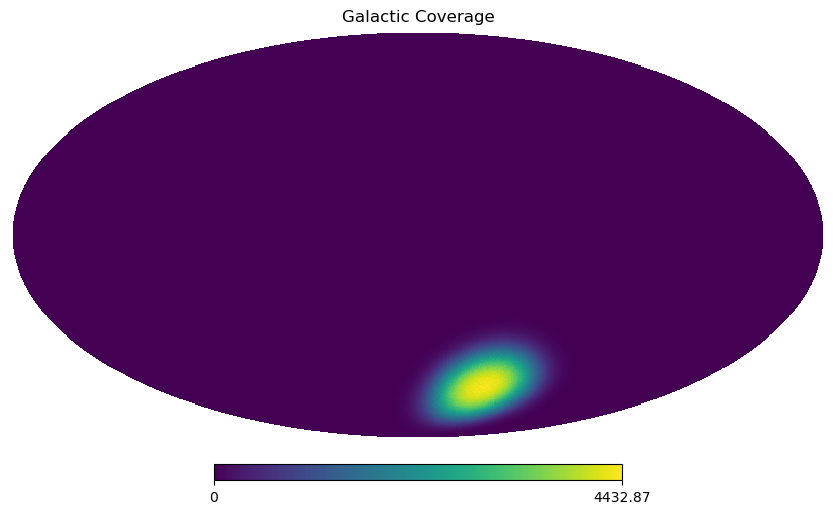

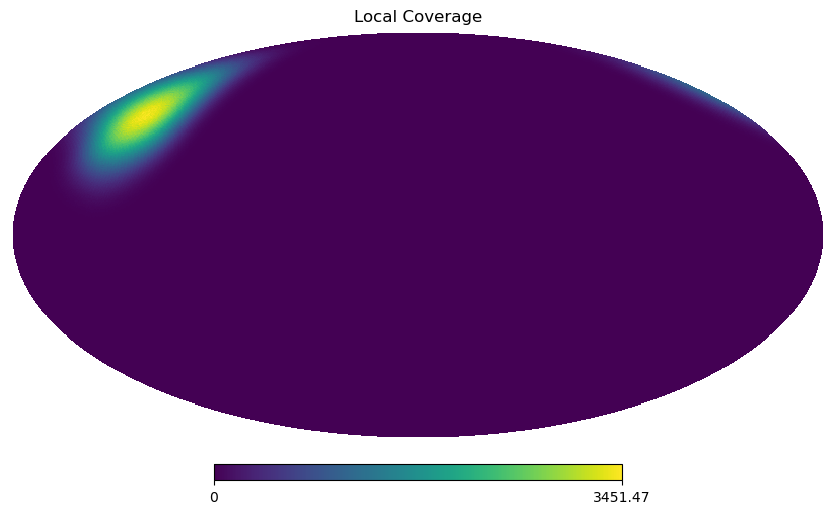

In [19]:
# Test coverage
hp.mollview(coverage_gal, title="Galactic Coverage")
hp.mollview(coverage_local, title="Local Coverage")

# Build QUBIC Operaotors

In [20]:
# Galactic Coordinates

H_gal = q_acquisition_gal.get_operator()

invN_gal = IdentityOperator() #q_acquisition_gal.get_invntt_operator()

print("H_gal", H_gal.shapein, H_gal.shapeout)
print("invN_gal", invN_gal.shapein, invN_gal.shapeout)

H_gal (8, 196608, 3) (9920000,)
invN_gal None None


In [21]:
# Local Coordinates

H_local = q_acquisition_local.get_operator()

invN_local = IdentityOperator() #q_acquisition_local.get_invntt_operator()

print("H_local", H_local.shapein, H_local.shapeout)
print("invN_local", invN_local.shapein, invN_local.shapeout)

H_local (8, 196608, 3) (9920000,)
invN_local None None


In [22]:
### Full MM
R = ReshapeOperator((2 * 992, params["npointings"]), (params["npointings"] * 992 * 2))

r = ReshapeOperator((npix, 3), (1, npix, 3))
A_gal = (
    DenseOperator(
        MixingMatrix[:, 0, None],
        broadcast="rightward",
        shapein=(1, npix, 3),
        shapeout=(params["nsub_in"], npix, 3),
    )
    * r
)
A_local = (
    DenseOperator(
        MixingMatrix[:, 1, None],
        broadcast="rightward",
        shapein=(1, npix, 3),
        shapeout=(params["nsub_in"], npix, 3),
    )
    * r
)

H = BlockRowOperator([H_gal(A_gal), H_local(A_local)], axisin=0) * ReshapeOperator(
    (2, npix, 3), (2 * npix, 3)
)
print(H.shapein, H.shapeout)
invN = R(invN_gal(R.T))
print(invN.shapein, invN.shapeout)

tod = H(true_maps)
print(tod.shape)

(2, 196608, 3) (9920000,)
(9920000,) (9920000,)
(9920000,)


In [23]:
print("H", H.shapein, H.shapeout)
print("invN", invN.shapein, invN.shapeout)
print("True maps", true_maps.shape)
print("tod", tod.shape)

H (2, 196608, 3) (9920000,)
invN (9920000,) (9920000,)
True maps (2, 196608, 3)
tod (9920000,)


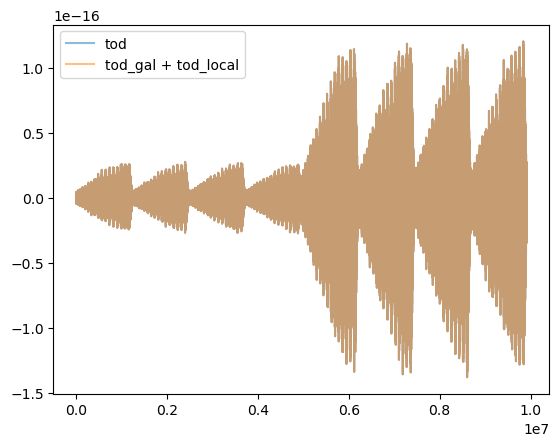

Difference between tod and tod_gal + tod_local :  []


In [24]:
### Test to verify if tod = tod_gal + tod_local

tod_gal = H_gal(A_gal(true_maps[0]))
tod_local = H_local(A_local(true_maps[1]))

plt.plot(tod.ravel(), label="tod", alpha=0.5)
plt.plot((tod_gal + tod_local).ravel(), label="tod_gal + tod_local", alpha=0.5)
plt.legend()
plt.show()

print(
    "Difference between tod and tod_gal + tod_local : ",
    np.setdiff1d(tod.ravel(), (tod_gal + tod_local).ravel()),
)

# Map-Making

In [25]:
mask = np.ones((2, npix, 3))          # Mask for 2 components : CMB & Atm
mask[0, :, 0] = 0                     # CMB Intensity
mask[1, :, [1,2]] = 0                 # Atm Polarisation
P = PackOperator(mask).T              # Build Mask Operator

#(ReshapeOperator(PackOperator(mask).shapeout, (2, npix, 2)) * PackOperator(mask)).T

x_masked = true_maps * (1-mask)

In [26]:
print(P.shapein, P.shapeout)
print(invN.shapein, invN.shapeout)
print(H.shapein, H.shapeout)

(589824,) (2, 196608, 3)
(9920000,) (9920000,)
(2, 196608, 3) (9920000,)


In [27]:
# Ax=b equation to be solve by PCG
A = P.T * H.T * invN * H * P
b = P.T * H.T * invN * (tod - H(x_masked))

# I start from an atm map for the CMB and from a cmb map for the atmosphere
x0 = P.T(true_maps.copy() * 0.)

In [28]:
print("A", A.shapein, A.shapeout)
print("b", b.shape)
print("x0", x0.shape)

A (589824,) (589824,)
b (589824,)
x0 (589824,)


In [29]:
# Run PCG

seenpix_pcg = np.array([seenpix_gal, seenpix_local])

algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-12,
    maxiter=50,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix_pcg,
    input=true_maps.copy(),
)
try:
    result = algo.run()
    success = True
    message = "Success"
except AbnormalStopIteration as e:
    result = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 1.8170e-01 4.23259 [0. 0. 0. 0. 0. 0.]
   2: 1.3705e-01 4.17445 [0. 0. 0. 0. 0. 0.]
   3: 7.8146e-02 4.20198 [0. 0. 0. 0. 0. 0.]
   4: 5.3246e-02 4.30397 [0. 0. 0. 0. 0. 0.]
   5: 4.2004e-02 4.20182 [0. 0. 0. 0. 0. 0.]
   6: 2.9606e-02 4.09943 [0. 0. 0. 0. 0. 0.]
   7: 2.2691e-02 4.16230 [0. 0. 0. 0. 0. 0.]
   8: 2.0601e-02 4.14345 [0. 0. 0. 0. 0. 0.]
   9: 1.4109e-02 4.15365 [0. 0. 0. 0. 0. 0.]
  10: 1.3090e-02 4.16140 [0. 0. 0. 0. 0. 0.]
  11: 1.0636e-02 4.17856 [0. 0. 0. 0. 0. 0.]
  12: 9.7570e-03 4.18841 [0. 0. 0. 0. 0. 0.]
  13: 8.8845e-03 4.34736 [0. 0. 0. 0. 0. 0.]
  14: 8.2239e-03 4.44229 [0. 0. 0. 0. 0. 0.]
  15: 7.2646e-03 4.24996 [0. 0. 0. 0. 0. 0.]
  16: 6.3245e-03 4.26979 [0. 0. 0. 0. 0. 0.]
  17: 5.7164e-03 4.30111 [0. 0. 0. 0. 0. 0.]
  18: 5.2809e-03 4.39062 [0. 0. 0. 0. 0. 0.]
  19: 4.5995e-03 4.29821 [0. 0. 0. 0. 0. 0.]
  20: 4.5058e-03 4.18242 [0. 0. 0. 0. 0. 0.]
  21: 4.4020e-03 4.22328 [0. 0. 0. 0. 0. 0.]
  22: 3.9942e-03 4.19699 [0. 0.

Text(0, 0.5, 'Convergence')

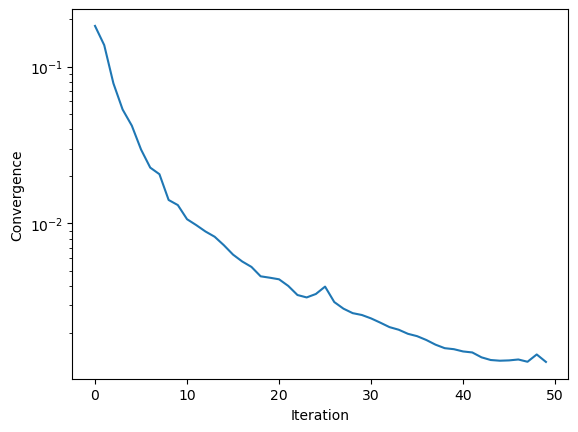

In [30]:
plt.plot(result["convergence"])
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Convergence")

In [31]:
input = P.T(true_maps).copy() #true_maps.copy()[..., 1:]
output = result["x"].copy()
residual = output - input

print("Input shape:", input.shape)
print("Output shape:", output.shape)
print("Residual shape:", residual.shape)

Input shape: (589824,)
Output shape: (589824,)
Residual shape: (589824,)


In [32]:
n_pix = hp.nside2npix(params["nside"])
# Reshape input and output to separate CMB and atmosphere components

input_cmb = input[: n_pix * 2].reshape(n_pix, 2)
input_atm = input[n_pix * 2 :].reshape(n_pix, 1)

output_cmb = output[: n_pix * 2].reshape(n_pix, 2)
output_atm = output[n_pix * 2 :].reshape(n_pix, 1)

residual_cmb = residual[: n_pix * 2].reshape(n_pix, 2)
residual_atm = residual[n_pix * 2 :].reshape(n_pix, 1)

# input_cmb = input[0]
# input_atm = input[1]

# output_cmb = output[0]
# output_atm = output[1]

# residual_cmb = residual[0]
# residual_atm = residual[1]

input_cmb[~seenpix_gal] = hp.UNSEEN
input_atm[~seenpix_local] = hp.UNSEEN
output_cmb[~seenpix_gal] = hp.UNSEEN
output_atm[~seenpix_local] = hp.UNSEEN
residual_cmb[~seenpix_gal] = hp.UNSEEN
residual_atm[~seenpix_local] = hp.UNSEEN

print("Input CMB shape:", input_cmb.shape)
print("Input Atmosphere shape:", input_atm.shape)

Input CMB shape: (196608, 2)
Input Atmosphere shape: (196608, 1)


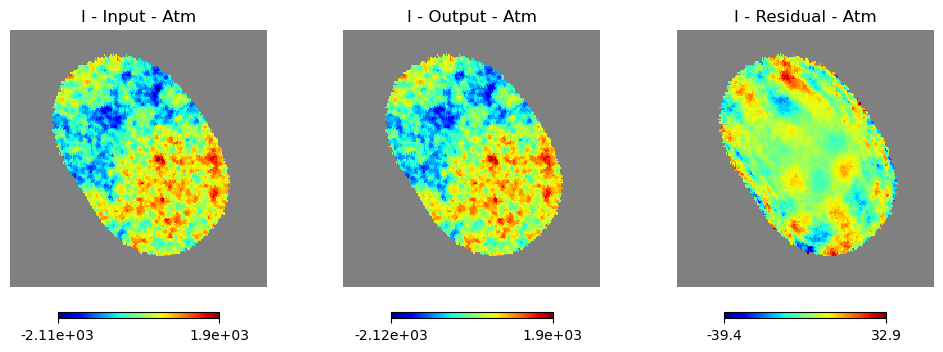

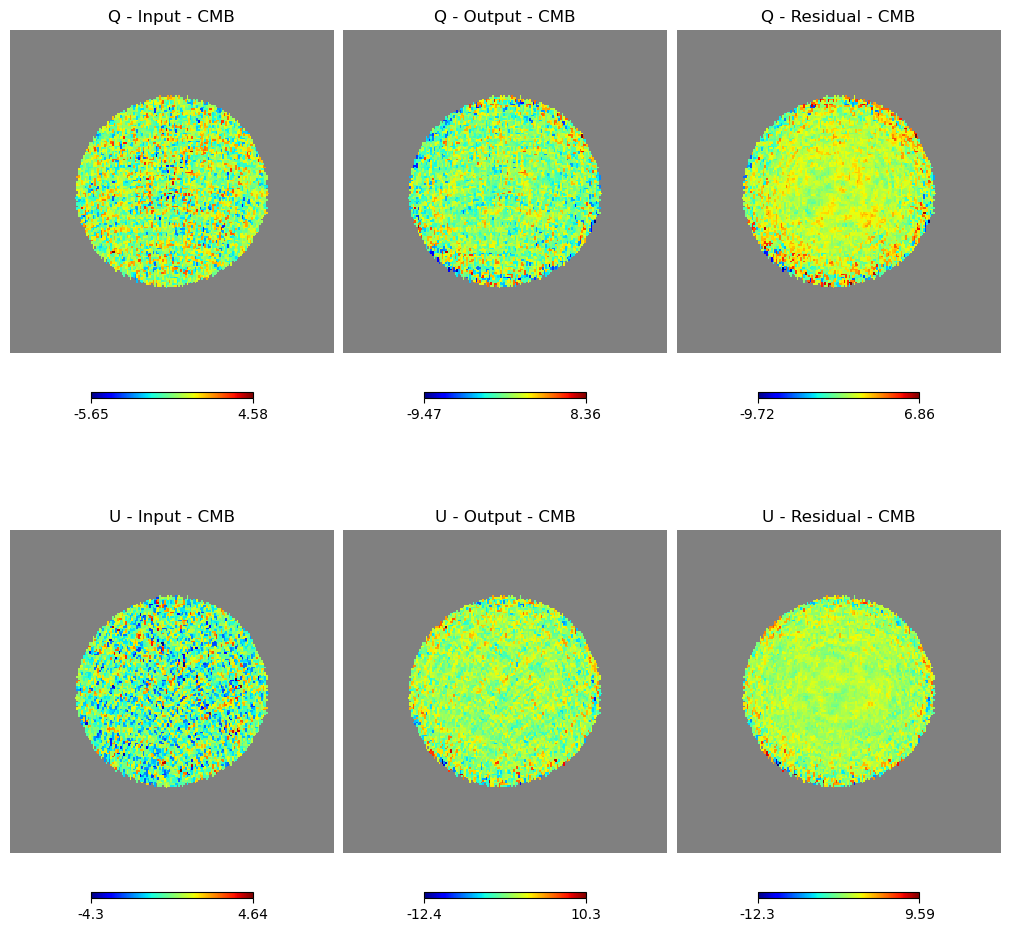

In [33]:
import matplotlib.pyplot as plt
import healpy as hp

# For Q/U only (istk = 0: Q, istk = 1: U)
stk = ["Q", "U"]
reso = 20

# ATMOSPHERE (I)
plt.figure(figsize=(10, 10))
atm_stk = ["I", "Q", "U"]
for istk in range(input_atm.shape[-1]):
    hp.gnomview(
        input_atm[:, istk],
        reso=reso,
        rot=center_local,
        cmap="jet",
        sub=(3, 3, istk*3 + 1),
        title=f"{atm_stk[istk]} - Input - Atm",
        notext=True,
    )
    hp.gnomview(
        output_atm[:, istk],
        reso=reso,
        rot=center_local,
        cmap="jet",
        sub=(3, 3, istk*3 + 2),
        title=f"{atm_stk[istk]} - Output - Atm",
        notext=True,
    )
    hp.gnomview(
        residual_atm[:, istk],
        reso=reso,
        rot=center_local,
        cmap="jet",
        sub=(3, 3, istk*3 + 3),
        title=f"{atm_stk[istk]} - Residual - Atm",
        notext=True,
    )
plt.tight_layout()

# CMB (Q, U)
plt.figure(figsize=(10, 10))
for istk in range(len(stk)):
    hp.gnomview(
        input_cmb[:, istk],
        reso=reso,
        rot=center_gal,
        cmap="jet",
        sub=(len(stk), 3, istk * 3 + 1),
        title=f"{stk[istk]} - Input - CMB",
        notext=True,
    )
    hp.gnomview(
        output_cmb[:, istk],
        reso=reso,
        rot=center_gal,
        cmap="jet",
        sub=(len(stk), 3, istk * 3 + 2),
        title=f"{stk[istk]} - Output - CMB",
        notext=True,
    )
    hp.gnomview(
        residual_cmb[:, istk],
        reso=reso,
        rot=center_gal,
        cmap="jet",
        sub=(len(stk), 3, istk * 3 + 3),
        title=f"{stk[istk]} - Residual - CMB",
        notext=True,
    )
plt.tight_layout()

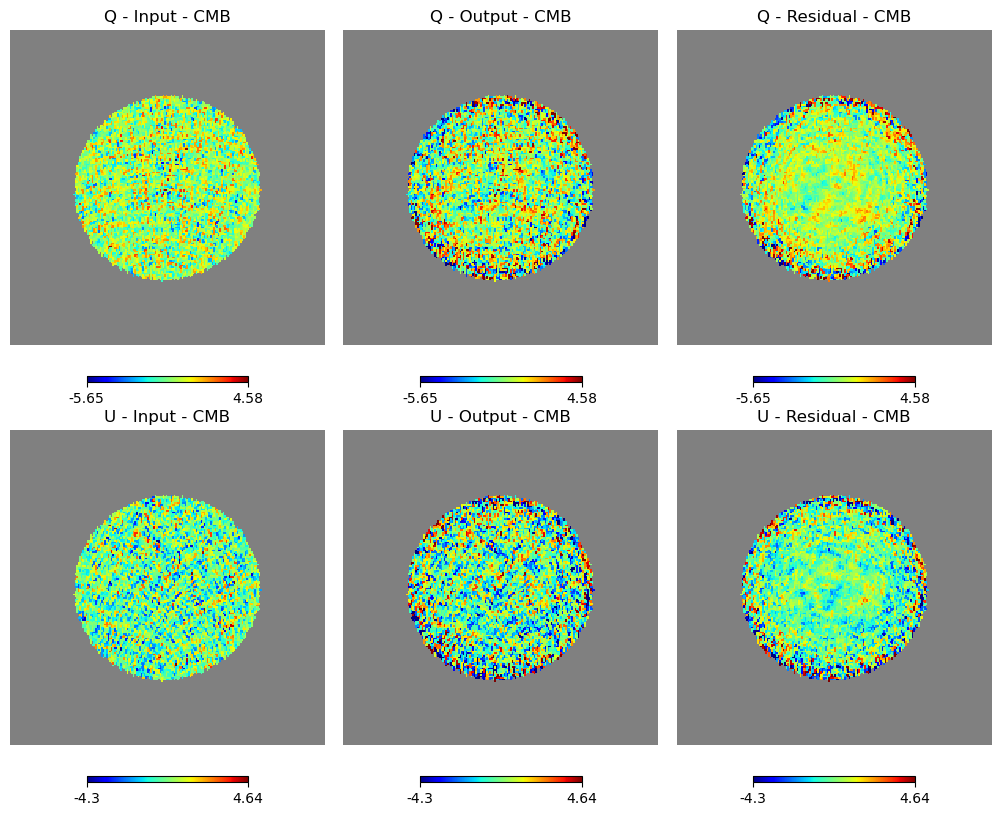

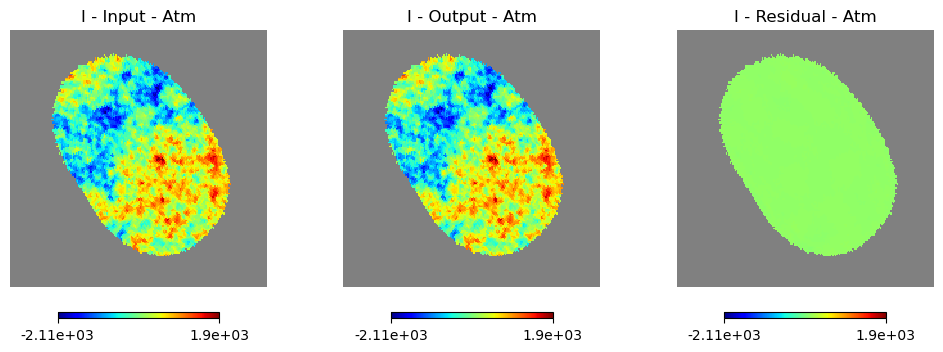

In [34]:
import matplotlib.pyplot as plt
import healpy as hp

# For Q/U only (istk = 0: Q, istk = 1: U)
stk = ["Q", "U"]
reso = 20

# CMB
plt.figure(figsize=(10, 8))
for istk in range(2):
    hp.gnomview(
        input_cmb[:, istk],
        reso=reso,
        rot=center_gal,
        cmap="jet",
        min=np.min(input_cmb[seenpix_gal, istk]),
        max=np.max(input_cmb[seenpix_gal, istk]),
        sub=(2, 3, istk * 3 + 1),
        title=f"{stk[istk]} - Input - CMB",
        notext=True,
    )
    hp.gnomview(
        output_cmb[:, istk],
        reso=reso,
        rot=center_gal,
        cmap="jet",
        min=np.min(input_cmb[seenpix_gal, istk]),
        max=np.max(input_cmb[seenpix_gal, istk]),
        sub=(2, 3, istk * 3 + 2),
        title=f"{stk[istk]} - Output - CMB",
        notext=True,
    )
    hp.gnomview(
        residual_cmb[:, istk],
        reso=reso,
        rot=center_gal,
        cmap="jet",
        min=np.min(input_cmb[seenpix_gal, istk]),
        max=np.max(input_cmb[seenpix_gal, istk]),
        sub=(2, 3, istk * 3 + 3),
        title=f"{stk[istk]} - Residual - CMB",
        notext=True,
    )
plt.tight_layout()

# ATMOSPHERE (I, Q, U)
plt.figure(figsize=(10, 10))
atm_stk = ["I", "Q", "U"]
for istk in range(input_atm.shape[-1]):
    hp.gnomview(
        input_atm[:, istk],
        reso=reso,
        rot=center_local,
        cmap="jet",
        min=np.min(input_atm[seenpix_local, istk]),
        max=np.max(input_atm[seenpix_local, istk]),
        sub=(3, 3, istk*3 + 1),
        title=f"{atm_stk[istk]} - Input - Atm",
        notext=True,
    )
    hp.gnomview(
        output_atm[:, istk],
        reso=reso,
        rot=center_local,
        cmap="jet",
        min=np.min(input_atm[seenpix_local, istk]),
        max=np.max(input_atm[seenpix_local, istk]),
        sub=(3, 3, istk*3 + 2),
        title=f"{atm_stk[istk]} - Output - Atm",
        notext=True,
    )
    hp.gnomview(
        residual_atm[:, istk],
        reso=reso,
        rot=center_local,
        cmap="jet",
        min=np.min(input_atm[seenpix_local, istk]),
        max=np.max(input_atm[seenpix_local, istk]),
        sub=(3, 3, istk*3 + 3),
        title=f"{atm_stk[istk]} - Residual - Atm",
        notext=True,
    )
    plt.tight_layout()